In [1]:
import EmbeddedCV
import cv2
import numpy as np
import os
from scipy.ndimage import convolve
from matplotlib import pyplot as plt
from matplotlib import rcParams
from QOI_encode import QOI_encode
from QOI_decode import QOI_decode

rcParams["figure.figsize"] = 14 ,7

# Test verifiers

In [2]:
import numpy as np

def check_correctness(y_pred, y):
    diff = y_pred.astype(np.int32) - y.astype(np.int32)
    abs_diff = np.abs(diff)
    max_diff = np.max(abs_diff)
    avg_diff = np.mean(abs_diff)

    diff_unacceptable = np.where(abs_diff > 2)

    if y_pred.shape[2] == 1:
        gray = True
    else: 
        gray = False

    cv2.imwrite("pred.png", y_pred)
    cv2.imwrite("true.png", y)
    cv2.imwrite("diff.png", abs_diff)

    fig, ax = plt.subplots(1,2)
    ax[0].axis("off")
    ax[1].axis("off")

    ax[0].set_title("Image processing pipeline")
    ax[1].set_title("Naive implementation")
    
    ax[0].imshow(cv2.cvtColor(y_pred, cv2.COLOR_BGR2RGB))
    ax[1].imshow(cv2.cvtColor(y, cv2.COLOR_BGR2RGB))

    print("Max diff:", max_diff)
    print("Avg diff:", avg_diff)
    print(sum(abs_diff.sum(axis=2).flatten() > 3))

    return True

# Naive implementations

In [3]:
from functions import gaussian_blur, canny_edge, sobel_min_max, median_blur

# Tests

Setup

In [4]:
device = False
snapshot = True

devicePath = "/dev/video0"

In [5]:
host = EmbeddedCV.Host()

if device:
    channels = 3
    rows = 360
    cols = 640
    snapshot = True
    cam = EmbeddedCV.CameraHS(devicePath, snapshot, channels, rows, cols)
else:
    channels = 3
    rows = 576
    cols = 768
    cam = EmbeddedCV.CameraSim(snapshot, channels, rows, cols)

host.Configure(cam)

Test cases

In [6]:
if device:
    image = np.zeros(shape=(channels*rows*cols), dtype=np.uint8)
    host.Sanity(image)
    image = image.reshape((rows, cols, channels))
else:
    image_path = "Background_Subtraction_Tutorial_frame_1.png"
    image = cv2.imread(image_path)

    flat_image = image.flatten()

    cam.StoreData(flat_image)

Sanity Check

In [7]:
# host_output = np.zeros(shape=(channels*rows*cols), dtype=np.uint8)

# host.Sanity(host_output)
# host_output = host_output.reshape((rows, cols, channels))

# naive_output = image

# check_correctness(y_pred=host_output, y=naive_output)

MedianBlur (0 error when min max buffers whole image)

In [8]:
# kernel_height, kernel_width = 3, 3

# host_output = np.zeros(shape=(channels*rows*cols), dtype=np.uint8)

# host.MedianBlur(host_output, kernel_height, kernel_width)
# host_output = host_output.reshape((rows, cols, channels))

# naive_output = median_blur(image, kernel_height, kernel_width)

# check_correctness(y_pred=host_output, y=naive_output)

GaussianBlur

In [9]:
# kernel_height, kernel_width = 5, 5
# sigma_x, sigma_y = 1, 1

# host_output = np.zeros(shape=(channels*rows*cols), dtype=np.uint8)

# host.GaussianBlur(host_output, kernel_height, kernel_width, sigma_x, sigma_y)
# host_output = host_output.reshape((rows, cols, channels))

# naive_output = gaussian_blur(image, kernel_height, kernel_width, sigma_x, sigma_y)

# check_correctness(y_pred=host_output, y=naive_output)

Sobel

Max diff: 77
Avg diff: 0.2715868537808642
15857


True

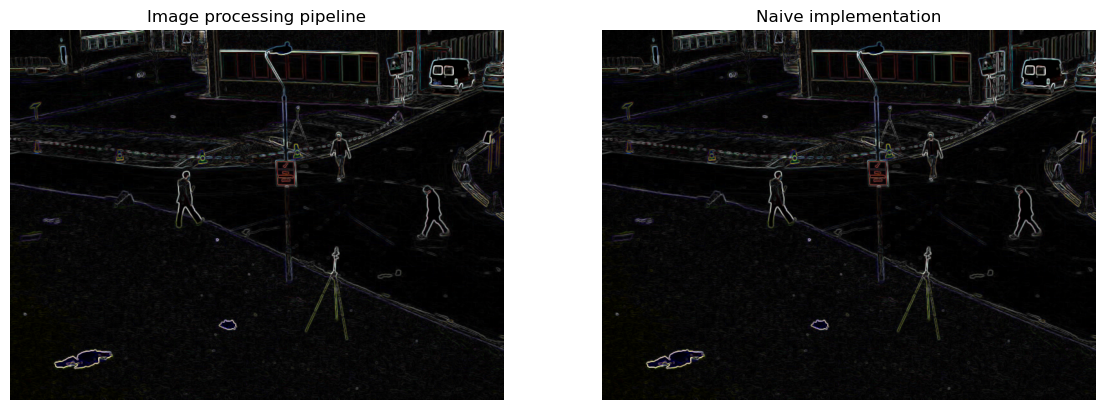

In [14]:
host_output = np.zeros(shape=(channels*rows*cols), dtype=np.uint8)

host.Sobel(host_output)
host_output = host_output.reshape((rows, cols, channels))

naive_output = sobel_min_max(image)

check_correctness(y_pred=host_output, y=naive_output)

CannyEdge

In [11]:
# lowThreshold = 100
# highThreshold = 200

# host_output = np.zeros(shape=(1*rows*cols), dtype=np.uint8)
 
# host.CannyEdge(host_output, lowThreshold, highThreshold)
# host_output = host_output.reshape((rows, cols, 1))

# naive_output = canny_edge(image, lowThreshold, highThreshold)

# check_correctness(y_pred=host_output, y=naive_output)

QOI

In [12]:
# QOI_encode(flat_image, channels, rows, cols)

In [13]:
# QOI_decode("img.bin")